In [1]:
import numpy as np
import matplotlib.pyplot as plt

from imripy import constants as c, merger_system as ms, halo, inspiral, plot_utils as pu, kepler

This notebook gives a simple example on how to extend the code.
As a toy problem, we will try to model the orbital drag the ISS experiences. 

In [2]:
# First, some earth parameters
m_earth = 3e-6 * c.solar_mass_to_pc  # Earth mass is 3e-6 solar masses
r_earth = 6371. * 1e3*c.m_to_pc  # Earth radius 6371 km 

hs_earth = ms.HostSystem(m_earth)

In [3]:
# And ISS parameters, taken from wikipedia
m_iss = 4.5e5 * c.kg_to_pc
surface_area_iss = 109. * 73. * c.m_to_pc**2

r_iss_min = r_earth + 413. * 1e3*c.m_to_pc
r_iss_max = r_earth + 422. * 1e3*c.m_to_pc
a_iss = (r_iss_min + r_iss_max) / 2.
e_iss = (r_iss_max - r_iss_min) / 2. / a_iss

ko_iss = kepler.KeplerOrbit(hs_earth, m_iss, a_iss, e_iss)

Now we can extend the halo.MatterHalo class to model our atmosphere.

We take a simple exponential ansatz (which is not a great approximation at ISS distance)

The mass function can be provided explicitly, or the density is integrated numerically.

In [4]:
class Atmosphere(halo.MatterHalo):
    def __init__(self, r_0, rho_0, scale_height):
        super().__init__(name="Atmosphere")
        self.r_0 = r_0
        self.rho_0 = rho_0
        self.scale_height = scale_height

    def density(self, r):
        return np.where(r >= self.r_0, 
                         self.rho_0 * np.exp(- (r - self.r_0) / self.scale_height),
                        0.)

In [5]:
# Atmospheric parameters
rho_0_earth = 1.225e-3 *c.g_cm3_to_invpc2  # 1.225 kg/m^3
scale_height_earth = 10.4  * 1e3*c.m_to_pc # 10.4 km

at_earth = Atmosphere(r_earth, rho_0_earth, scale_height_earth)

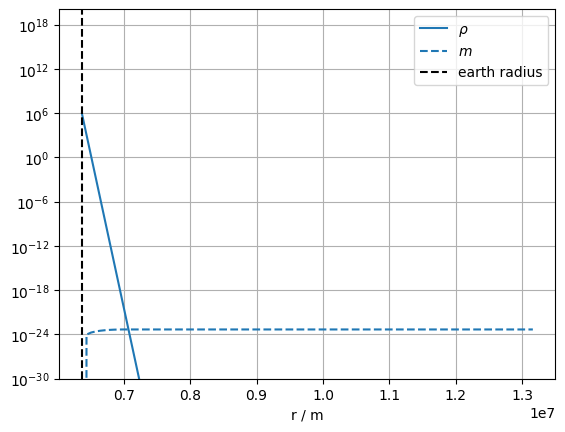

In [6]:
r_grid = np.linspace(r_earth, r_earth + a_iss, 100)

l, = plt.plot(r_grid/ c.m_to_pc, at_earth.density(r_grid), label=r'$\rho$')
plt.plot(r_grid / c.m_to_pc, at_earth.mass(r_grid), linestyle='--', color=l.get_c(), label='$m$')
plt.axvline(r_earth/c.m_to_pc, color='black', linestyle='--', label="earth radius")
plt.grid(); plt.xlabel("r / m"); plt.yscale('log'); plt.ylim(bottom=1e-30); plt.legend()

Here, we create the drag force the ISS experiences, as simple geometric drag inside a gaseous medium.

Since the force is antiparallel to the velocity, we can use the inspiral.forces.DissipativeForceSS class.
If e.g. the gas is also moving relative to the earth, the force can point in a different direction. There is already a GasGeometricDrag class implemented that handles this.

The only real function we have to provide is F, the force assumed to be antiparallel to the velocity of the secondary. The `halo` is our atmosphere, and this can be either directly provided to the GeometricDrag class, or taken from the HostSystem object as hs.halo.
Then, the force is calculated from all the parameters and returned.
The base class then converts this force to the energy and angular momentum loss by averaging over the orbit, and this is in turn converted to the changes in semimajor axis and eccentricity.

If the force is not antiparallel, the signature is a bit more complicated, see the forces in imripy.inspiral.forces. Once F is specified, it can also calculate dE/dt, dL/dt, and di/dt for the inclination angle.

In [7]:
class GeometricDrag(inspiral.forces.DissipativeForceSS):
    name = "GeometricDrag"

    def __init__(self, surface_area, halo = None, C_drag= 1.):
        self.surface_area = surface_area
        self.halo = halo
        self.C_drag = C_drag

    def F(self, hs, ko, r, v, opt):
        """
        The function gives the force of the geomtric drag of an object inside a gaseous halo at radius r
            and with velocity v

        Parameters:
            hs (HostSystem) : The object describing the properties of the host system
            ko (KeplerOrbit): The Kepler orbit object describing the current orbit
            r  (float)      : The radius of the secondary (as in total distance to the MBH)
            v  (float)      : The total velocity
            opt (EvolutionOptions): The options for the evolution of the differential equations

        Returns:
            out : float
                The magnitude of the drag force
        """
        halo = self.halo or hs.halo
        
        F_gd = 2* self.C_drag  * self.surface_area * halo.density(r) * v**2
        return F_gd

In [8]:
gd = GeometricDrag(surface_area_iss, halo=at_earth)

In [9]:
opt = inspiral.Classic.EvolutionOptions( dissipativeForces=[gd]) # we only want our newly defined drag force

# now solve the differential equations until the earth is hit
ev = inspiral.Classic.Evolve(hs_earth, ko_iss, opt=opt, a_fin=r_earth)

Evolving from  254647320.60185188  to  238986238.42592594 r_isco  with initial eccentricity 0.0006628857626869252  with  Options: dissipative forces employed {GeometricDrag, }, accuracy = 1.0e-10


/media/data/Documents/PhD/imripy/src/imripy/kepler.py:240: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt(self.m_tot *(2./r - 1./self.a))
/tmp/ipykernel_4875/1292279335.py:10: RuntimeWarning: overflow encountered in exp
  self.rho_0 * np.exp(- (r - self.r_0) / self.scale_height),
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:241: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:264: RuntimeWarning: invalid value encountered in sqrt
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(ko.m_tot * a*(1.-e**2))* quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:264: IntegrationWarning: The occurrence of roundoff error is detected, which preven

Required step size is less than spacing between numbers.
 -> Ended at 2.421e+08r_isco. Evolution took 0.6737s real time


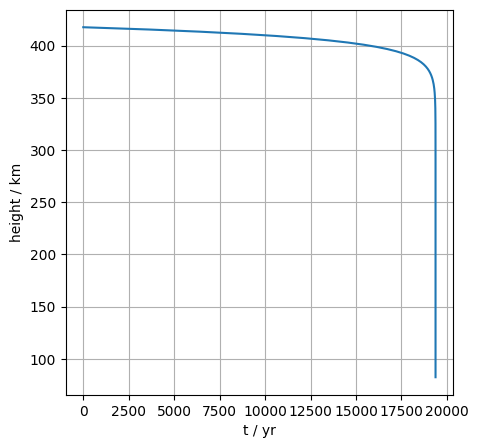

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.plot(ev.t / c.year_to_pc, (ev.a - r_earth)/c.m_to_pc/1e3)
ax.set_xlabel("t / yr"); ax.set_ylabel("height / km"); ax.grid()

Of course, this is not a realistic example. Once the ISS is sufficiently inside the atmosphere, the forces become too strong and the resulting trajectory is certainly not Keplerian anymore.

This is just a toy problem to see how easily the code can be extended. 
According to wikipedia, the ISS loses 2km/month, if not boosted by the docked rockets.
We are just a few order of magnitude off, this is probably because of the oversimplified atmospheric model.

In [11]:
da_dt = np.gradient(ev.a / c.m_to_pc / 1e3, ev.t / c.year_to_pc * 12.)  # convert to km / month
print(da_dt[0])

-5.063853502614781e-05


Note: The gas drag here is circularizing, so the initialy eccentricity is washed away. If the force were eccentrifying and the orbit highly eccentric, passing a_fin is not sufficient. This is because on an eccentric orbit, the surface can be hit while the semimajor axis is still larger.

To adapt to this, we can use the opt.additionalEvents structure and create an event that triggers when the surface is actually hit. The event handling is according to scipy.solve_ivp. As an example we could do this

In [12]:
a_scale = ko_iss.a
# in the internal integration y[0] is a in a_scale, with a_scale set to the initial semimajor axis
# and y[1] is the eccentricity 0<=e<1
# y[2] is the secondary's mass, y[3] the periapse angle, and y[4] the inclination angle
surface_hit = lambda t,y, *args: a_scale*y[0]*(1. - y[1]) - r_earth  # the lowest point in the orbit is given by a*(1-e)
surface_hit.terminal = True
opt.additionalEvents = [surface_hit]